# $E_\text{peak} - E_\text{iso}$ correlation, introducing errors

In the previous notebook ([Epeak_Eiso_correlation.ipynb](https://github.com/joanalnu/OAB-INAF/blob/main/Epeak_Eiso_correlation.ipynb)), we computed a fit for this relation from the data from $\textit{Ghirlanda et al. 2008}$. However, the goodness of fit function didn't take into account the error uncertainty in neither axis of the scatter and also didn't account for the fit error. The aim of this notebook is to perform the same fit (between $E_\text{peak}$ and $E_\text{iso}$ following the model $Y=k+mx$, where $y$ and $x$ are the logarithms of the data), this time accounting for errors (and paying attention to the correct propagation formulas!). We still won't be constraining cosmological parameters.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('table.csv') # read the data from Ghirlanda et al. 2008

def get_float(col):
    return np.array([float(base) * 10**float(exponent) for val in col for base, exponent in [str(val).split('e')]])

The first step is to take the logarithm of the data, were we will apply the correct formula for the errors, since we can't do
$$E\pm\sigma_E \not\implies \log_{10}(E)\pm\log_{10}(\sigma_E) \mathcal{!!}$$.

We approach the issue by defining a function $y$ and differentiating it.
$$
\begin{align*}
    y&= log_{a} x \quad; \text{ in our case } a=10 \\
    a^y &= x \\
    \frac{d}{dx} a^y &= \frac{d}{dx} x \quad; \text{ since y = y(x) we use the chain rule} \\
    ln(a) a^y \frac{dy}{dx} &= 1 \quad; a^y = x \\
    dy &= \frac{dx}{ln(a)x}
\end{align*}
$$
Now, by assuming that the errors are small (in comparison with the distance between values), we can write $\sigma_{E, \log} = \sigma_E / (E\times\ln10)$.

In [2]:
Epeak = np.log10(df['Epeak']) # keV
Epeak_err = df['Epeak_err'] / (df['Epeak'] * np.log(10)) # correct error propagation

Eiso = np.log10(get_float(df['Eiso'])) # ergs
Eiso_err = df['Eiso_err'] / (df['Eiso'] * np.log(10))

Text(0, 0.5, '$log(E_{\\text{peak}})$')

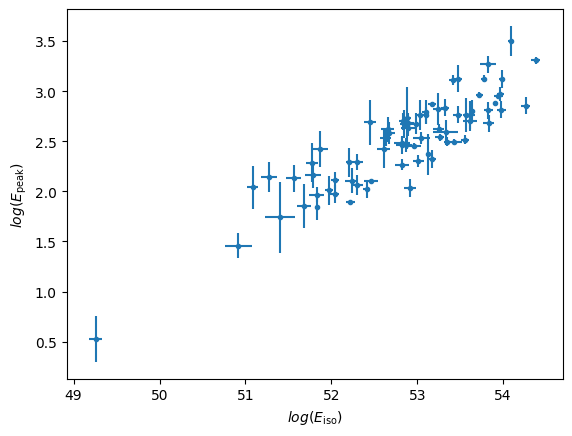

In [3]:
plt.figure()
plt.errorbar(Eiso, Epeak, xerr=Eiso_err, yerr=Epeak_err, fmt='.')

plt.xlabel(r'$log(E_{\text{iso}})$')
plt.ylabel(r'$log(E_{\text{peak}})$')

Next, we'll go ahead with the fitting of the parameters, remember that we want to fit the logarithm of the data to the model $y = k +mx$. But now we also want to take the errors into account. Continuing with the goodness of fit (`GoF`) approach, we will redefine $\chi^2$ to take the errors into account, i.e. computing a weighted fit.
$$\chi^2 = \sum_i \frac{r_i^2}{\sigma_{r,i}^2}$$
where $r_i = O_i + E_i$ are the residuals and $\sigma_{r,i}^2$ is the variance of the residuals for $i$. So we must find a way of deriving this variance from $\sigma_{E_\text{peak}}$ and $\sigma_{E_\text{iso}}$. We can do that by using the formula of error propagation theory defined for a function $r(x,y) = y - (k+mx)$:
$$\sigma^2 = \frac{\partial r}{\partial x} \sigma_x^2 + \frac{\partial r}{\partial y} \sigma_y^2 + \frac{\partial r}{\partial x} \frac{\partial r}{\partial y} \text{Cov}(x,y)$$
The term with the covariance matrix $(\text{Cov}(x,y))$, accounts for the correlation between the errors. For now, we'll assume that the errors are _not_ correlated, therefore drop this term $(\text{Cov}(x,y)=0)$ and proceed partially differentiating.
$$\begin{align*}
    \frac{\partial r}{\partial x} &= m \\
    \frac{\partial r}{\partial y} &= 1 \\
 \end{align*}$$
 substituting both
 $$\chi^2 = \sum_i \frac{y-(k+mx)}{m\sigma_{x,i}^2 + \sigma_{y,i}^2}$$



Next we'll try to find a fit for these GRB properties ($E_{\text{peak}}$ - $E_{\text{iso}}$). As explained above, this will be a power-law: $E_{\text{peak}} = m \cdot E_{\text{iso}}^q$. I will use a goodness of fit function (using the $\chi^2$ method and a parameter space $(m,q)$ to find the 'best fit'.

In [9]:
def gof(param1,param2,x=Eiso,y=Epeak,x_err=Eiso_err,y_err=Epeak_err):
    """
    Goodness of fit following the chi-squared formula with error propagation.
    :param param1: y-axis cut (parameter k)
    :param param2: slope (parameter m)
    :param x: x-values
    :param y: y-values
    :param x_err: uncertainties in x-values
    :param y_err: uncertainties in y-values
    :return: chi-squared value
    """

    model = param1+ param2*x

    total_variance = y_err**2
    total_variance += (param2*x_err)**2

    return np.sum(((y-model)**2)/total_variance)

In [10]:
k = np.linspace(-25.,-20.,100) # inferred from previous scatter plot
m = np.linspace(.0,1.,100) # slope of power-law must be positive

G = np.zeros([len(k),len(m)])
for i in range(len(k)):
    for j in range(len(m)):
        G[i][j] = gof(k[i],m[j])

best_fit = np.argmin(G)
k_index, m_index = np.unravel_index(best_fit, G.shape)
k_fit, m_fit = k[k_index], m[m_index]
print(k_index, m_index, k_fit, m_fit)

4 51 -24.7979797979798 0.5151515151515152


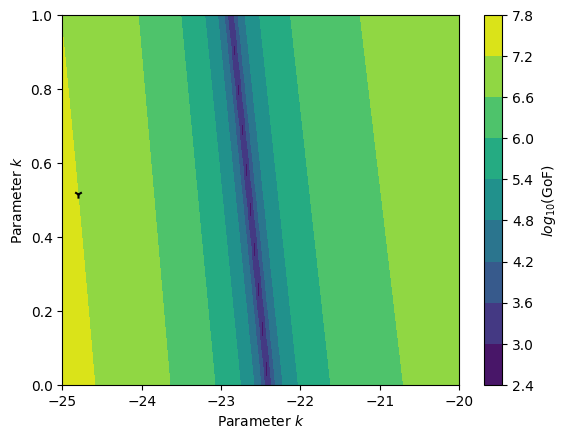

In [11]:
fig = plt.figure()
plt.contourf(k,m,np.log10(G))
plt.colorbar(label=r'$log_{10}(\text{GoF})$')
plt.xlabel(r'Parameter $k$')
plt.ylabel(r'Parameter $k$')
plt.scatter(k_fit, m_fit, c='black', marker='1')

Since we are getting a weird surface plot again, we will extract the mininum value manually again, just to make sure. Then we will plot the resulting line over the data.

In [16]:
minimum = 100000
coords = [0,0]
for i in range(len(k)):
    for j in range(len(m)):
        if np.log10(G[i][j]) < minimum:
            minimum = np.log10(G[i][j])
            coords = [k[i],m[j]]

print(minimum, coords)

2.7364364362681433 [np.float64(-24.7979797979798), np.float64(0.5151515151515152)]


Text(0, 0.5, 'Epeak')

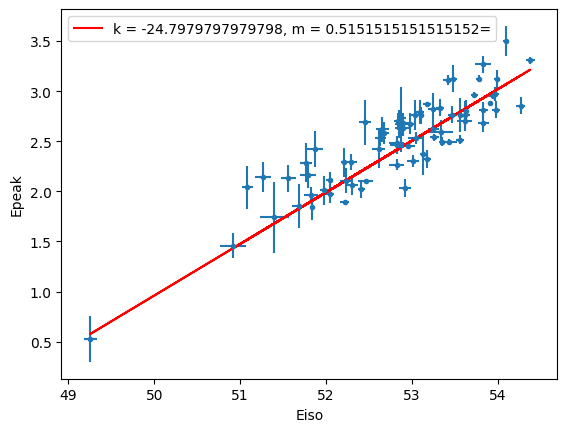

In [28]:
plt.figure()
plt.errorbar(Eiso, Epeak, xerr=Eiso_err, yerr=Epeak_err, fmt='.')
plt.plot(Eiso, k_fit+(Eiso*m_fit), color='r', label=f'k = {k_fit}, m = {m_fit}=')

plt.legend()
plt.xlabel('Eiso')
plt.ylabel('Epeak')